# Playing Azul with Deep Reinforcement Learning

Deep reinforcement learning is a technique that combines deep neural networks and reinforcement learning, and it could largely improve the accuracy and precision of some policy-making models. [This paper](https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd?fbclid=IwAR1CiRCE0a5nrZBQs2A2Ezw3fh3VUg7JWFC0m8ZKNDIp4xOzqPuhUmTgYQk), titled "A general reinforcement learning algorithm that masters chess, shogi and Go through self-play", showed how this was possible in a groundbreaking achievement of reinforcement learning. In this homework, you will re-implement some of the key parts of this paper to train an agent that learns to play new games.

## 1. Basic Structure (with Tic-Tac-Toe as an example)

For the approach described in the paper, the deep neural network learns a map:

$$f(s; \theta) = (p, v).$$
        
The map (with parameters $\theta$) takes in a state $s$ and outputs a vector of move probabilities $p$ and an estimate of the outcome $v$. The vector of probabilities $p$ is called a *policy*.



In [1]:
!pip install jax
!pip install flax
!pip install optax
!pip install networkx
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 4.9 MB/s 
     |████████████████████████████████| 8.3 MB 55.5 MB/s 
     |████████████████████████████████| 237 kB 61.1 MB/s 
     |████████████████████████████████| 154 kB 44.5 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax
import jax.numpy as jnp                             # JAX NumPy

from flax import linen as nn                        # The Linen API
from flax import traverse_util
from flax.training import train_state, checkpoints  # Useful dataclass to keep train state

import numpy as np                                  # Ordinary NumPy
import optax                                        # Optimizers
import matplotlib.pyplot as plt
import networkx as nx

from Azul_Simulator import *                        # Azul simulator
from Azul_Visuals import *                          # Azul visualizer

### 1) Simulating the Game

You will need to first implement the `get_next_state` and `get_reward` functions. The following information will be useful:


*   The tic-tac-toe board is represented by a 9x1 vector that would be a row-major representation of the 3x3 board.
*   Each entry in that vector is either 0 (empty), 1 (marked by player 1), or -1 (marked by player 2).
*   An action is simply the index of our 9x1 vector that we would like to mark.

In [3]:
def init_board():
  return np.zeros((3, 3), dtype=int).flatten()

def flip_board(board):
  # Used to change the current player
  return -board

def get_valid_mask(board):
  return board == 0

def get_next_state(board, action):
  ################################################################################################
  # TODO: Return the state that would result in taking the given action using the given board
  # Hint: Always assume the action is made by player 1
  ################################################################################################
  if(?): # Under what conditions would the given action be illegal?
    print("Illegal Move")
    print(board.reshape((3,3)))
    print(action)
    print(get_reward(board))
    assert False
  next_board = board.copy()
  next_board[action] = ?
  ################################################################################################
  # END OF YOUR CODE
  ################################################################################################
  return next_board

def sample_action(action_dist):
  # Randomly choose an action
  action_dist = action_dist.flatten() / action_dist.sum()
  return np.random.choice(action_dist.shape[0], p=action_dist)

def disp_board(board):
  # Used to display the board
  plt.imshow(board)

diag_mask = np.eye(3)
ld_mask = np.eye(3)[::-1, :]
def get_reward(board):
  ################################################################################################
  # TODO: Implement the reward function. We first calculate whether there is a win diagonally,
  # horizontally, or vertically. Then we return the reward and whether or not the game has ended.
  ################################################################################################
  b = board.reshape((3,3))
  diag = ? <= -3
  diag_l = ? <= -3
  row = ? <= -3
  col = ? <= -3
  reward = -int(diag or diag_l or row or col)
  return reward, ? # Remember the game can end without a win
  ################################################################################################
  # END OF YOUR CODE
  ################################################################################################

Run the following cell to test the basic functinoality of the get_next_state and get_reward functions. 

In [4]:
for _ in range(200):
  board = init_board()
  for _ in range(10):
    action_dist = np.ones(board.shape) * get_valid_mask(board)
    next_action = sample_action(action_dist)
    board = flip_board(get_next_state(board, next_action))
    reward, game_over = get_reward(board)
    if(game_over):
      break
print ("No issues encountered!")

No issues encountered!


### 2) Monte Carlo Tree Search

The paper uses the Monte Carlo Tree Search (MCTS) algorithm, which you will help implement in the cell below.

Each round of Monte Carlo tree search consists of four steps:

**Selection**: Start from root $R$ and select successive child nodes until a leaf node $L$ is reached. The root is the current game state and a leaf is any node that has a potential child from which no simulation (playout) has yet been initiated.

**Expansion**: Unless $L$ ends the game decisively (e.g. win/loss/draw) for either player, create one (or more) child nodes and choose node $C$ from one of them. Child nodes are any valid moves from the game position defined by $L$.

**Simulation**: Complete one random playout from node $C$. This step is sometimes also called playout or rollout. A playout may be as simple as choosing uniform random moves until the game is decided (for example in chess, the game is won, lost, or drawn).

**Backpropagation**: Use the result of the playout to update information in the nodes on the path from $C$ to $R$.

From the AlphaZero paper: Each state-action pair $(s, a)$ stores a set of statistics, $\{N(s, a), W(s, a), Q(s, a), P(s, a)\}$, where $N(s, a)$ is the visit count, $W(s, a)$ is the total action-value, $Q(s, a)$ is the mean action-value, and $P(s, a)$ is the prior probability of selecting $a$ in $s$. Each simulation begins at the root node of the search tree, $s_0$, and finishes when the simulation reaches a leaf node $s_L$ at time-step $L$. At each of these timesteps, $t < L$, an action is selected, $a_t = argmax_a(Q(s_t, a) + U(s_t, a))$, using a variant of the PUCT algorithm, $U(s, a) = C(s)P(s, a)\sqrt{N(s)}/(1 + N(s, a))$, where $N(s)$ is
the parent visit count and $C(s)$ is the exploration rate, which grows slowly with search time, $C(s) = log ((1 + N(s) + c_{base})/c_{base}) + c_{init}$, but is essentially constant during the fast training games.

The stochastic policy obtained after performing the MCTS uses exponentiated counts, i.e. 
$$π(s)=N(s,⋅)^{1/τ}/∑_b(N(s,b)^{1/τ})$$, where $τ$ is the temperature and controls the degree of exploration. AlphaGo Zero uses $τ = 1$ (simply the normalised counts) for the first 30 moves of each game, and then sets it to an infinitesimal value (picking the move with the maximum counts).

In [5]:
def toy_model(state):
    return np.ones(state.shape) / state.shape[0], 0.0123

STATE_DIM = 9 # Dimension of 3x3 tic-tac-toe board
ACTION_DIM = 9
MAX_SIZE = int(1e3)
C_BASE, C_INIT = 3.0, 1.0
class MCTS:
    def __init__(self, max_size=MAX_SIZE, exp_rate=3.0):
        self.state = np.zeros((max_size, STATE_DIM))
        self.state_lookup = {} #Maps state representation to index
        self.expanded = []

        self.visit_count = np.zeros(max_size)
        self.action_visits  = np.zeros((max_size, ACTION_DIM), dtype=int)
        self.action_total_value = np.zeros((max_size, ACTION_DIM))
        self.action_mean_value = np.zeros((max_size, ACTION_DIM))
        self.action_prior = np.zeros((max_size, ACTION_DIM))

        self.exp_rate = exp_rate
    
    #Assumes state is already expanded, and uses MCTS info to pick best action using weighted combination of 
    #model prior and MCTS value estimates
    def select_action(self, state, state_index):
        ################################################################################################
        # TODO: Implement action selection.
        #   1) Get the distribution of all possible actions (Hint: using formulas given above)
        #   2) Choose the best action and return it
        ################################################################################################
        state_visits = ?
        exp_rate = self.exp_rate
        model_prior = ?
        sa_visits = ?
        sa_mean_value = (1 + ?) / 2 #Normalize [-1, 1] to [0, 1]
        action_distr = (sa_mean_value + exp_rate*np.sqrt(state_visits)*model_prior/(1+sa_visits))#*get_valid_mask(state)
        action_distr -= (~get_valid_mask(state))*1e5
        action = ?
        if(state[action] != 0):
            print("State", state.reshape((3,3)))
            print("action", action)
            print("exp rate", exp_rate)
            print("sa mean value", sa_mean_value, sa_visits)
            print("action distr", action_distr)
            print("model prior", model_prior)
            print("action_mask", get_valid_mask(state))
        return action
        ################################################################################################
        # END OF YOUR CODE
        ################################################################################################

    def get_action_prob(self, state_index, temperature=1):
        ################################################################################################
        # TODO: Select action according to the visit count distribution and the temperature.
        #   Hint: using formulas given above
        ################################################################################################
        action_visits = self.action_visits[state_index]
        if temperature == 0:
            # START YOUR CODE
            raise NotImplementedError
            # END YOUR CODE
        elif temperature == float("inf"):
            # START YOUR CODE
            raise NotImplementedError
            # END YOUR CODE
        else:
            # See paper appendix Data Generation
            visit_count_distribution = np.power(action_visits, 1 / temperature)
            visit_count_distribution = visit_count_distribution / sum(visit_count_distribution)
            return visit_count_distribution
        ################################################################################################
        # END OF YOUR CODE
        ################################################################################################
    
    #Add a new node to the mcts tree for the state, and model prior for actions on that state
    def expand_node(self, state, action_probs):
        ################################################################################################
        # TODO: Expand the action probability of child nodes.
        #   1) Store expanded state
        #   2) Store all probabilities of valid moves
        ################################################################################################
        state_index = len(self.expanded)
        self.expanded.append(True)
        self.state_lookup[state.tobytes()] = ?

        self.state[state_index] = ?
        self.visit_count[state_index] += 1

        valid_moves = ?
        action_probs = (action_probs + 1e-6) * valid_moves  # mask invalid moves
        action_probs /= np.sum(action_probs)
        self.action_prior[state_index] = action_probs
        return state_index
        ################################################################################################
        # END OF YOUR CODE
        ################################################################################################

    def search_iter(self, state_index, model):
        search_path = []
        path_actions = []

        curr_index = state_index
        curr_state = self.state[state_index]

        ################################################################################################
        # TODO: Loop until you reach an untracked state.
        #   1) Store each index in search_path and relative action in path_action
        #   2) Select an action based on curr_state and curr_index
        #   3) Update curr_state based on curr_state (Hint: remember to flip the board to change the turn)
        #   4) Find the index of next state and end the iteration if next index is not found
        ################################################################################################
        while curr_index >= 0:
            # BEGIN YOUR CODE
            raise NotImplementedError
            # END YOUR CODE

        # The value of the new state from the perspective of the other player
        next_state = curr_state
        value, game_over = get_reward(next_state)
        value = -value
        ################################################################################################
        # TODO: Expand the tree if the game has not ended.
        #   1) Get action_probs and value of next_state using given model
        #   2) Use masked and normalized action_prob to expand the node (Hint: use expand_node)
        ################################################################################################
        if not game_over:
            # BEGIN YOUR CODE
            raise NotImplementedError
            # END YOUR CODE
        
        ################################################################################################
        # TODO: Backpropagate MCTS search path.
        #   1) Get search index and action from search_path and path_actions
        #   2) Add relative value in visit_count, action_visits, action_total_value and 
        #      action_mean_value since this state and action are visited (Hint: use given variable 'value')
        #   3) Change the player (given in the code)
        ################################################################################################
        for i in range(len(search_path)-1, -1, -1):
            # BEGIN YOUR CODE
            raise NotImplementedError
            # END YOUR CODE
            value *= -1
        ################################################################################################
        # END OF YOUR CODE
        ################################################################################################
        
    def mcts_eval(self, state, model, num_sims):
        root_state = state
        action_prior, value_est = model(root_state)
        root_index = self.expand_node(root_state, action_prior)
        for _ in range(num_sims):
            self.search_iter(root_index, model)
        return root_index
    
    def visualize_tree(self):
        G = nx.Graph()
        node_labels = {}
        edge_labels = {}
        for state_index in self.state_lookup.values():
            visited_actions = self.action_visits[state_index].nonzero()[0]
            action_values = self.action_mean_value[state_index, visited_actions]
            state = self.state[state_index]
            for action, value in zip(visited_actions, action_values):
                child_state = flip_board(get_next_state(state, action))
                if(child_state.tobytes() in self.state_lookup):
                    child_index = self.state_lookup[child_state.tobytes()]
                    G.add_edge(state_index, child_index)
                    edge_labels[(state_index, child_index)] = f'{value:.2f}'
            node_labels[state_index] = f"{state_index}, {self.action_visits[state_index].sum()}" 

        plt.figure()
        pos = nx.spring_layout(G, scale=2.5)
        nx.draw(
            G, pos, edge_color='black', width=1, linewidths=1, node_size=1000, 
            node_color='pink', alpha=0.9,
            labels=node_labels
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels=edge_labels,
            font_color='red'
        )
        plt.axis('off')
        plt.title("MCTS Graph Visualization")
        plt.show()

Now we can try a few simple situations to test whether our model can correctly evaluate positions. 

In [6]:
# In the simplest case, the game can be won in one move
winning_state = np.array([1, 0,  0, 0, 1,  0, 0,  0, 0])
print("Board Initial State\n", winning_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(winning_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

print("MCTS Visit Counts") # Board shows how many times the MCTS revisited each potential move. 
print(mcts.action_visits[0].reshape((3,3)))

Board Initial State
 [[1 0 0]
 [0 1 0]
 [0 0 0]]
MCTS Expected Action Value
[[0.         0.42882333 0.45042258]
 [0.34378846 0.         0.25205   ]
 [0.43538333 0.41591379 1.        ]]
MCTS Visit Counts
[[  0  30  31]
 [ 26   0  24]
 [ 30  29 330]]


### 3) Written Questions

### Q1
Mathematically, why is the visit count highest for the winning move? Why does the algorithm try other moves as well? 

### A1

Board Initial State
 [[ 1  1 -1]
 [-1  0  0]
 [-1  0  0]]
MCTS Expected Action Value
[[ 0.          0.          0.        ]
 [ 0.          0.83796296 -0.749385  ]
 [ 0.         -0.44       -0.52227391]]


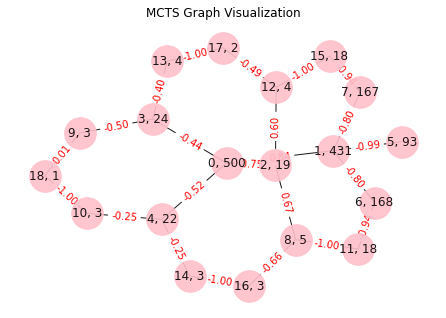

In [7]:
root_state = np.array([1, 1,  -1, -1, 0,  0, -1,  0, 0])
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

print("MCTS Expected Action Value")
print(mcts.action_mean_value[0].reshape((3,3)))

mcts.visualize_tree()

#### The code above shows the MCTS rollout for another state, in which the game can be won with a move at the center, and is lost otherwise with perfect play. The MCTS rollout correctly converges to a high value for the center move, and negative values for everything else. 

### Q2
In the limit of MCTS depth, should the tree converge to a value of 1.0 for the center move? 

### A2

### Q3
The tree above shows how often each state is visited, and shows the estimated value of actions stemming from each state along edges. Why do so many edges in the tree have a value of 0.1? **Hint:** Look at the outputs of the toy model. 

### A3

### Q4
How should the value estimate for the center square change is the MCTS exploration rate is increased? Why? 

### A4

# Full MCTS Visualization
Tic-tac-toe is a small enough game that it's possible to plot the entire MCTS for some subsets. In the following code, we plot the states visited in MCTS, along with the number of times the tree search took actions to visit that state, and the estimated value of the action leading to this state from tree search. 

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from matplotlib.collections import LineCollection

# create discrete colormap
cmap = colors.ListedColormap(['red', 'grey', 'blue'])
bounds = [-2, -0.5, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

def box_pos(num_box, layer_level, spacing, offset=0.0):
    offset = spacing*offset
    draw_pos = [(i*1.5*spacing+offset, -layer_level+offset) for i in range(num_box)]
    return draw_pos

def draw_edges(ax, dp1, dp2, edges):
    segments = []
    for p, c in edges:
        segments.append(((dp1[p], dp2[c])))
    line_segments = LineCollection(segments, linestyles='solid', color='red', zorder=0)
    ax.add_collection(line_segments)

def draw_layer(ax, to_print, draw_pos, spacing):
    gx = np.linspace(0, 0.6, 4)
    for pos, t in zip(draw_pos, to_print):
        x, y = pos
        state, text = t
        state = state.reshape((3,3))
        ax.pcolormesh(gx*spacing+x, gx*spacing+y, state, shading='flat', cmap=cmap)
        if(spacing > 0.1):
            ax.text(x+0.65*spacing, y, text)


def plot_mcts(ax, mcts, root_index): 
    layer = [root_index]
    value, count = mcts.action_mean_value[root_index].max(), mcts.visit_count[root_index]
    to_print = [(mcts.state[root_index], f"Visits: {count}\nValue: {value:.2f}")]

    to_print_l = [to_print]
    edges_l = []

    layer_row = 0
    while len(layer) > layer.count(-1):
        next_layer = []
        to_print = []
        edges = []
        seen_states = {}
        for parent_i, state_index in enumerate(layer):
            if(state_index < 0):
                continue
            state = mcts.state[state_index]
            visited_actions, = np.nonzero(mcts.action_visits[state_index])
            visit_counts = mcts.action_visits[state_index][visited_actions]
            action_values = mcts.action_mean_value[state_index, visited_actions]
            for action, count, value in zip(visited_actions, visit_counts, action_values):
                child_state = flip_board(get_next_state(state, action))
                if(child_state.tobytes() in seen_states): #Child already in next layer
                    child_i = seen_states[child_state.tobytes()]
                    edges.append((parent_i, child_i))
                    continue

                if(child_state.tobytes() in mcts.state_lookup): #Child in MCTS
                    child_index = mcts.state_lookup[child_state.tobytes()]
                    valid_moves = get_valid_mask(child_state)
                    child_value = mcts.action_mean_value[child_index][valid_moves].max()
                    next_layer.append(child_index)
                elif(get_reward(child_state)[1]): #Child is end-state
                    next_layer.append(-1)
                    child_value = -value
                else:
                    continue

                child_i = len(to_print)
                edges.append((parent_i, child_i))
                seen_states[child_state.tobytes()] = child_i
                to_print.append((child_state, f"{count}\n{child_value:.2f}"))
        to_print_l.append(to_print)
        edges_l.append(edges)
        layer_row += 1
        layer = next_layer

    spacing_l = np.array([min(0.3, 2/(len(to_print)+1e-4)) for to_print in to_print_l])
    layer_level_l = np.cumsum(spacing_l+0.5)

    draw_pos = box_pos(len(to_print_l[0]), layer_level_l[0], spacing_l[0], offset=0.3)
    for i in range(1, len(to_print_l)):
        next_draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i], offset=0.3)
        draw_edges(ax, draw_pos, next_draw_pos, edges_l[i-1])
        draw_pos = next_draw_pos
    
    for i in range(len(to_print_l)):
        draw_pos = box_pos(len(to_print_l[i]), layer_level_l[i], spacing_l[i])
        draw_layer(ax, to_print_l[i], draw_pos, spacing_l[i])
    # draw_pos = box_pos(len(to_print), layer_level, spacing)

#### The visualization code will show how the MCTS evaluates our earlier position. The value associated with each board state is the maximum of the return from each possible action for the state. 
#### **Note**: The state flips colors each turn so that each move is considered from the perspective of the blue player. 

Board Initial State
 [[ 1  1 -1]
 [-1  0  0]
 [-1  0  0]]


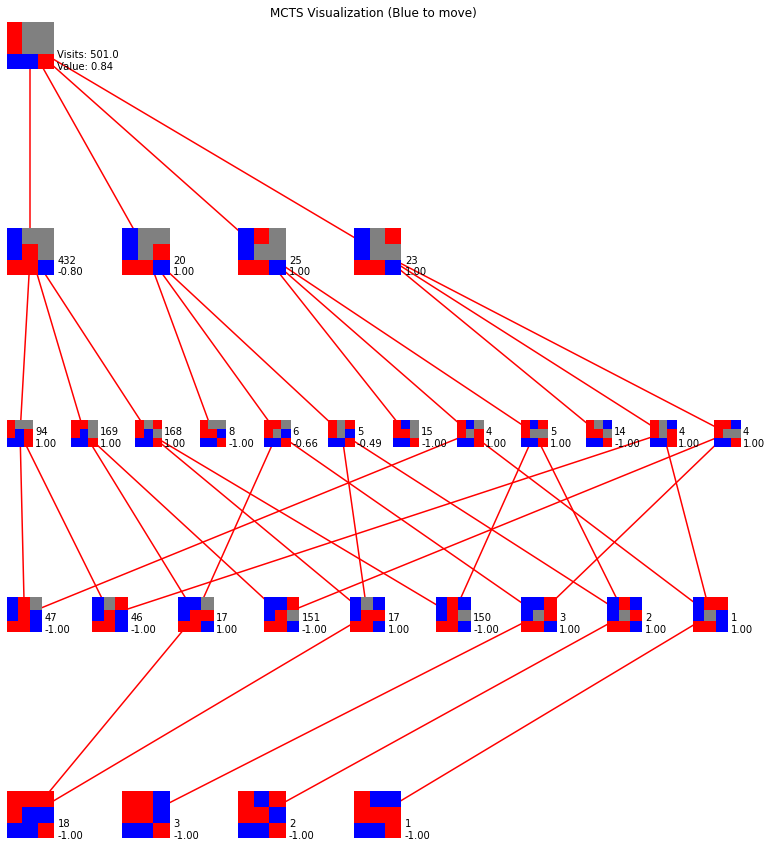

In [9]:
root_state = np.array([1, 1,  -1, -1, 0,  0, -1,  0, 0])
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 500)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
ax.set_title("MCTS Visualization (Blue to move)")
fig.show()

### High branching factor visualization

Board Initial State
 [[ 1 -1  0]
 [ 0  0  0]
 [ 0  0  0]]


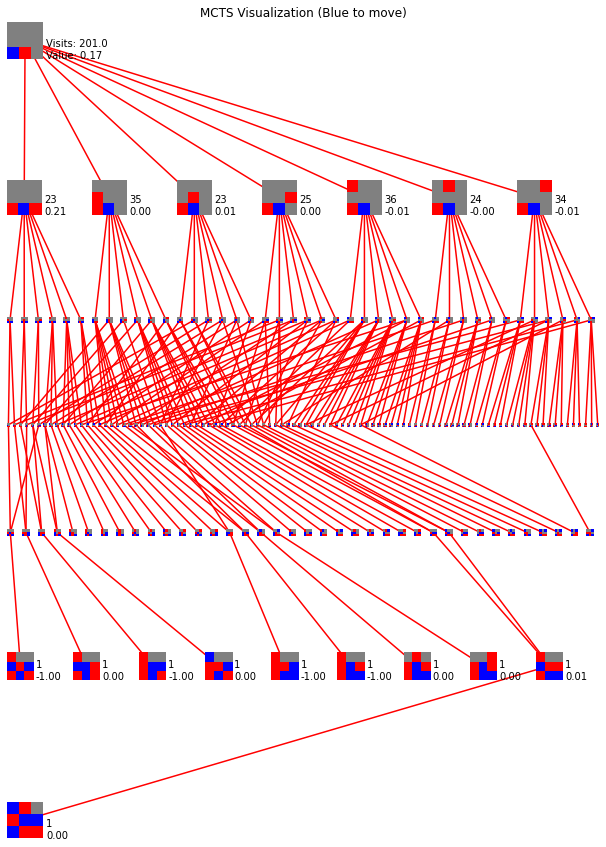

In [10]:
root_state = np.array([1, -1,  0, 0, 0,  0, 0,  0, 0])
# root_state = np.zeros(9)
print("Board Initial State\n", root_state.reshape((3,3)))
mcts = MCTS(max_size=5000)
mcts.mcts_eval(root_state, toy_model, 200)

fig, ax = plt.subplots(figsize=(15, 15))
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_frame_on(False)
ax.set_aspect('equal')
plot_mcts(ax, mcts, 0)
ax.set_title("MCTS Visualization (Blue to move)")
fig.show()

### Model Training (Self-Play Episodes)
If we're convinced by our visualizations that the MCTS is correctly evaluating move quality, we can move onto training our model. The first step is to generate example games through self-play, which can be used as training data for the model. 

Implement get_action_prob for the MCTS class. In the self-play loop below, observe how get_action_prob is used to sample potentially valuable actions at each step of gameplay. 

In [11]:
def self_play_episode(model, num_sims=50, temp_threshold=6):
    train_examples = []
    board = init_board()
    step = 0
    while True:
        mcts = MCTS()
        root_index = mcts.mcts_eval(board, model, num_sims=num_sims)
        
        temp = int(step < temp_threshold)
        pi = mcts.get_action_prob(root_index, temperature=temp)

        train_examples.append((board, pi, step))

        action = np.random.choice(ACTION_DIM, p=pi)
        
        board = flip_board(get_next_state(board, action))

        # Reward is always negative because board is flipped after move. 
        r, game_over = get_reward(board) 
        if(game_over):
            return [(b, p, r*(-1)**(step-s-1)) for b, p, s in train_examples]
        step += 1

def batch_examples(train_examples):
    state_batch = jnp.stack([t[0] for t in train_examples])
    pa_batch = jnp.stack([t[1] for t in train_examples])
    r_batch = jnp.stack([t[2] for t in train_examples]).reshape((-1, 1))
    return state_batch, pa_batch, r_batch

### Q5
The temperature parameter changes from 1 to 0 after the 6th move. What are the effects of this change? Why would they improve training? 

### A5

In [12]:
train_examples = self_play_episode(toy_model, num_sims=1000)
state_b, pa_b, r_b = batch_examples(train_examples)
print("Single Game Rollout")
for b, r in zip(state_b, r_b):
    print("State\n", b.reshape((3,3)))
    print("Reward", r[0])

Single Game Rollout
State
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
Reward 1.0
State
 [[ 0  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
Reward -1.0
State
 [[ 0  0  0]
 [ 0  1  0]
 [ 0 -1  0]]
Reward 1.0
State
 [[ 0  0  0]
 [ 0 -1  0]
 [-1  1  0]]
Reward -1.0
State
 [[ 0  0  0]
 [-1  1  0]
 [ 1 -1  0]]
Reward 1.0


### Q6 
Why is the reward flipped between each state in the training rollout?

### A6

### Jax/Flax Training
For training, we use the Jax/Flax packages. The TTTModel takes in a tic-tac-toe board state, and needs to return two outputs, a set of logits giving the probability of making each possible move, and a value between -1 and 1 estimating the expected value of the state, with 1 representing certain victory, and -1 representing certain defeat. 

In [13]:
from jax import jit

class TTTModel(nn.Module):
  """A simple MLP model."""
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=1024)(x)
    x = nn.relu(x)
    body = nn.Dense(features=1024)(x)
    body = nn.relu(body)
    logits = nn.Dense(features=9)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) # Value estimate between -1 and 1
    return logits, value

@jit
def model_agent(x, params): 
  # A version of the model that returns actual probability values instead of logits, which are usually used for numerical stability
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

model = TTTModel()
rng = jax.random.PRNGKey(42)
params = model.init(rng, board)

# Model Optimization
The reinforcement model optimizes two objectives at once. First, it attempts to match it's estimated distribution for moves with the MCTS estimate for moves by minimizing cross entropy. Second, it attempts to minimize the square error of it's value estimates against the actual values from the training rollout. Both should be optimized in train_step below.

In [14]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  model = TTTModel()
  params = model.init(rng, jnp.ones([1, 9]))['params']

  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, state_b, pa_b, r_b):
  """Train for a single step."""
  def loss_fn(params):
    logits, exp_value = TTTModel().apply({'params': params}, state_b)
    loss = optax.softmax_cross_entropy(logits, pa_b).mean() + jnp.square(r_b - exp_value).mean()
    return loss, (logits, exp_value)
  grad_fn = jax.grad(loss_fn, has_aux=True)
  grads, aux = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [15]:
def learned_agent(board, state):
    prior = model_agent(board, {'params': state.params})[0]
    prior *= get_valid_mask(board)
    return np.argmax(prior)

def random_agent(board):
    valid_mask = np.float32(get_valid_mask(board))
    valid_mask /= valid_mask.sum()
    return np.random.choice(board.shape[0], p=valid_mask)

def play_match(agent1, agent2):
    board = init_board()
    agents = [agent1, agent2]
    step = 0
    while True:
        a = agents[step%2](board)
        board = flip_board(get_next_state(board, a))
        reward, game_over = get_reward(board)
        if(game_over):
            return reward**step
        step += 1

#Write code to evaluate the win, loss, and draw percentage of agent1 against agent2. Make sure you have equal numbers of games with
#agent1 going first or second
def match_average(agent1, agent2):
    matches = []
    for i in range(100):
        matches.append(play_match(agent1, agent2))
        matches.append(-play_match(agent2, agent1))
    return (matches.count(1)/2, matches.count(-1)/2, matches.count(0)/2)

# AlphaZero Training Loop
The alphazero training loop works by generating games with MCTS assisted self-play, and then using the results and gamestates from those games to update the model parameters. A few batches in the loop below should bring the model to around a 60% win rate against a random opponent. 

In [16]:
state = create_train_state(rng, 0.01, 0.1)
win_percentage = []
for i in range(15):
    print(f"Batch {i}")
    train_examples = []
    for i in range(10):
        train_examples += self_play_episode(lambda x: model_agent(x, {'params': state.params}), num_sims=150)
    state_b, pa_b, r_b = batch_examples(train_examples)
    state = train_step(state, state_b, pa_b, r_b)
    win, loss, draw = match_average(lambda s:learned_agent(s, state), random_agent)
    print(f"Against random: Wins {win}%, Losses {loss}%, Draws {draw}%")
    win_percentage.append(win)

Batch 0
Against random: Wins 35.5%, Losses 53.0%, Draws 11.5%
Batch 1
Against random: Wins 33.0%, Losses 45.5%, Draws 21.5%
Batch 2
Against random: Wins 35.0%, Losses 46.5%, Draws 18.5%
Batch 3
Against random: Wins 43.0%, Losses 40.0%, Draws 17.0%
Batch 4
Against random: Wins 36.5%, Losses 50.0%, Draws 13.5%
Batch 5
Against random: Wins 41.5%, Losses 43.0%, Draws 15.5%
Batch 6
Against random: Wins 44.0%, Losses 45.5%, Draws 10.5%
Batch 7
Against random: Wins 41.0%, Losses 44.0%, Draws 15.0%
Batch 8
Against random: Wins 40.0%, Losses 52.5%, Draws 7.5%
Batch 9
Against random: Wins 49.0%, Losses 41.5%, Draws 9.5%
Batch 10
Against random: Wins 50.5%, Losses 39.5%, Draws 10.0%
Batch 11
Against random: Wins 54.0%, Losses 41.0%, Draws 5.0%
Batch 12
Against random: Wins 50.5%, Losses 39.0%, Draws 10.5%
Batch 13
Against random: Wins 53.5%, Losses 39.0%, Draws 7.5%
Batch 14
Against random: Wins 55.0%, Losses 31.5%, Draws 13.5%


### Can the model prevent an instant loss?

In [17]:
model = TTTModel()

board = np.array([1, -1, 0, -1, 1, 0, -1, 0, -1])
print("Board State")
print(board.reshape((3,3)))
action_prior, value = model.apply({'params': state.params}, board)
print("Model Distribution")
print((action_prior*get_valid_mask(board)).reshape((3,3)), value)

Board State
[[ 1 -1  0]
 [-1  1  0]
 [-1  0 -1]]
Model Distribution
[[ 0.          0.         -0.18763702]
 [ 0.          0.         -0.1333947 ]
 [ 0.         -0.17181785  0.        ]] [-0.15928441]


### Yes! 
The model correctly infers that the least-bad move is to block the immediate win. 

### Training directly from MCTS evaluations
The AlphaZero paper uses MCTS evaluations to guide games, which are used on their own as training data. However, for games as small as tic-tac-toe, the MCTS algorithm is able to cover a significant fraction of the state-space, making them a rich source of data on their own. Using the code framework below, try training the model directly from states and state evaluations estimated by a deep MCTS run. 

### Q7
For this simple problem setting, this approach actually trains much faster than the original to paper version shown above. Why would this approach be ineffective for more complicated games such as chess? 

### A7

In [18]:
def sample_state(mcts, visited_states):
    index = np.random.choice(visited_states)
    state = mcts.state[index]
    valid_mask = get_valid_mask(state)
    action_value = mcts.action_mean_value[index]# - valid_mask*1e4
    action_visits = mcts.action_visits[index]
    action_visits = action_visits / action_visits.sum()
    return state, action_visits, action_value[valid_mask].max()

mcts = MCTS(max_size=5001, exp_rate=2.1)
root_state = init_board()
mcts.mcts_eval(root_state, toy_model, num_sims=5000)
visited_states = np.arange(0, mcts.state.shape[0])[(mcts.visit_count > 4)]
print(sample_state(mcts, visited_states))

def sample_batch(mcts, visited_states, batch_size=100):
    res = []
    for i in range(batch_size):
        res.append(sample_state(mcts, visited_states))
    return batch_examples(res)

(array([ 0., -1.,  0.,  1.,  1.,  0., -1.,  1., -1.]), array([0.16666667, 0.        , 0.16666667, 0.        , 0.        ,
       0.66666667, 0.        , 0.        , 0.        ]), 1.0)


In [21]:
state = create_train_state(rng, 0.005, 0.1)
win_percentage = []
for i in range(5):
    print(f"Epoch {i}")
    mcts = MCTS(max_size=20001, exp_rate=2.1)
    root_state = init_board()
    mcts.mcts_eval(root_state, lambda x: model_agent(x, {'params': state.params}), num_sims=20000)
    visited_states = np.arange(0, mcts.state.shape[0])[(mcts.visit_count > 4)]
    for j in range(500):
        if j % 100 == 0:
            print("Starting batch #" + str(j))
        state_b, pa_b, r_b = sample_batch(mcts, visited_states, batch_size=100)
        state = train_step(state, state_b, pa_b, r_b)
    win, loss, draw = match_average(lambda s:learned_agent(s, state), random_agent)
    print(f"Against random: Wins {win}%, Losses {loss}%, Draws {draw}%")
    win_percentage.append(win)

Iteration #0
Starting batch #0
Starting batch #100
Starting batch #200
Starting batch #300
Starting batch #400
Epoch 0
Against random: Wins 64.5%, Losses 33.0%, Draws 2.5%
Iteration #1
Starting batch #0
Starting batch #100
Starting batch #200
Starting batch #300
Starting batch #400
Epoch 1
Against random: Wins 77.5%, Losses 16.5%, Draws 6.0%
Iteration #2
Starting batch #0
Starting batch #100
Starting batch #200
Starting batch #300
Starting batch #400
Epoch 2
Against random: Wins 77.5%, Losses 16.0%, Draws 6.5%
Iteration #3
Starting batch #0
Starting batch #100
Starting batch #200
Starting batch #300
Starting batch #400
Epoch 3
Against random: Wins 80.0%, Losses 14.0%, Draws 6.0%
Iteration #4
Starting batch #0
Starting batch #100
Starting batch #200
Starting batch #300
Starting batch #400
Epoch 4
Against random: Wins 89.5%, Losses 6.5%, Draws 4.0%


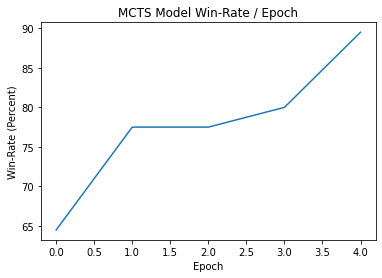

In [22]:
plt.plot(win_percentage)
plt.title("MCTS Model Win-Rate / Epoch")
plt.xlabel("Epoch")
plt.ylabel("Win-Rate (Percent)")
plt.show()

# Can the model select an instant win? 

In [23]:
model = TTTModel()
board = np.array([1, 1, 0, -1, -1, 0, -1, 0, -1])
print("Board State")
print(board.reshape((3,3)))
action_prior, value = model.apply({'params': state.params}, board)
print("Model Distribution")
print((action_prior*get_valid_mask(board)).reshape((3,3)), value)

Board State
[[ 1  1  0]
 [-1 -1  0]
 [-1  0 -1]]
Model Distribution
[[0.         0.         3.2362182 ]
 [0.         0.         0.6953783 ]
 [0.         0.37946904 0.        ]] [0.73342985]


### Evaluating Model Performance
Using either the default AlphaZero algorithm, or direct MCTS training, we can estimate the relative performance of the model by simulating games against naive agents, or look-ahead agents that estimate the value of each move with traditional tree search. 

The learned agent should consistently beat random agents, and should be on par with normal tree search. The best performing model should be the learned model integrated into tree search as a heuristic, as is used by AlphaZero for the highest performance. 

In [24]:
def mcts_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, lambda x: model_agent(x, {'params': state.params}), num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

def mcts_rand_agent(board):
    mcts = MCTS()
    root_index = mcts.mcts_eval(board, toy_model, num_sims=100)
    pi = mcts.get_action_prob(root_index, temperature=0)
    if(np.min(pi) < 0):
        print(board.reshape((3,3)))
        print(pi)
        assert False
    action = np.random.choice(ACTION_DIM, p=pi)
    return action

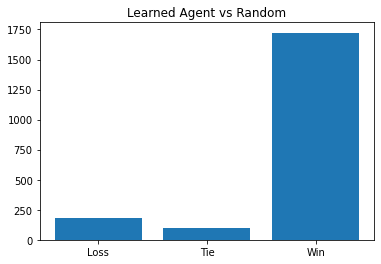

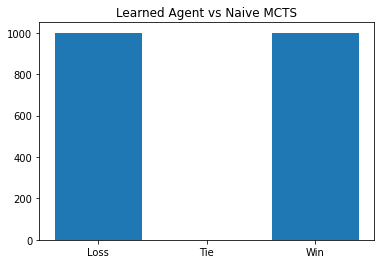

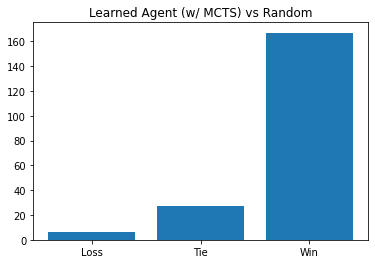

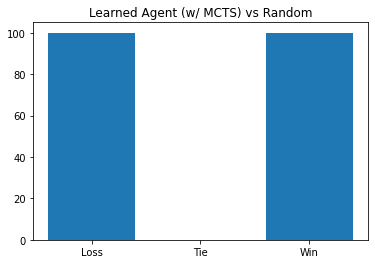

In [25]:
fig, axis = plt.subplots()
match_results = []
for i in range(1000):
    match_results.append(play_match(lambda s:learned_agent(s, state), random_agent))
    match_results.append(-play_match(random_agent, lambda s:learned_agent(s, state)))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent vs Random")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(1000):
    match_results.append(play_match(lambda s:learned_agent(s, state), mcts_rand_agent))
    match_results.append(-play_match(mcts_rand_agent, lambda s:learned_agent(s, state)))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent vs Naive MCTS")
fig.show()

fig, axis = plt.subplots()
match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, random_agent))
    match_results.append(-play_match(random_agent, mcts_agent))

counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent (w/ MCTS) vs Random")
fig.show()

match_results = []
for i in range(100):
    match_results.append(play_match(mcts_agent, mcts_rand_agent))
    match_results.append(-play_match(mcts_rand_agent, mcts_agent))

fig, axis = plt.subplots()
counts, bins = np.histogram(match_results, bins=[-1.1, -0.1, 0.1, 1.1])
axis.bar([-1, 0, 1], counts, tick_label=['Loss', 'Tie', 'Win'])
axis.set_title("Learned Agent (w/ MCTS) vs Random")
fig.show()

## 2. Deep Reinforcement Learning with Azul

Our original goal with this homework was to take things a step further and create an agent that would learn how to play the board game Azul (the rulebook for which can be found [here](https://tesera.ru/images/items/1108676/EN-Azul-Rules.pdf)). Unfortunately, we were unable to train an effective model that can play at anywhere close to the level of humans. However, we wanted to provide you with a chance to play against our model regardless. Afterwards, we'll also ask you a few questions that will give you a better idea of why (or at least why we think) we did not succeed to the same degree that we did with TIC-TAC-TOE.

To make a move while playing against our model, you'll enter in a 3 character input string. The letters of the input string corresponding to the following...
* index 0 - (C, 1, 2, 3, 4, 5) where to take tiles from
* index 1 - (B, Y, R, D, W) which color tile to take
* index 2 - (1, 2, 3, 4, 5, F) which row to place the tiles in    

Ex: 5B2 corresponds to taking all blue (B) tiles from factory #5 and placing
        them in the second row

Ex: CWF corresponds to taking all white (W) tiles from the center and placing
        them on the floor

IMPORTANT: To avoid redundancy, the letter D (dark) corresponds to black tiles


In [34]:
from Azul_Simulator import *
from Azul_Visuals import *
from jax import jit

# Load a pre-trained Azul model
class TTTModel(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=64)(x)
    body = nn.Dense(features=32)(x)
    x = nn.Dense(features=181)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) #Value estimate between -1 and 1
    return x, value

@jit
def model_agent(x, params):
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

def learned_agent(board, state):
    prior = model_agent(board, {'params': state['params']})[0] + 1e-10
    prior *= get_valid_mask(board)
    return np.argmax(prior)

CKPT_DIR = "ckpts"
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=None)

Welcome to the Azul simulator!



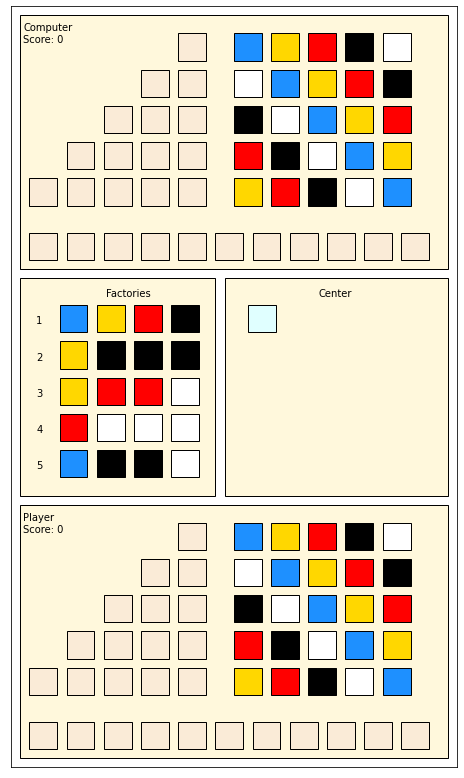

Player's turn...
Enter a move: 
4W4


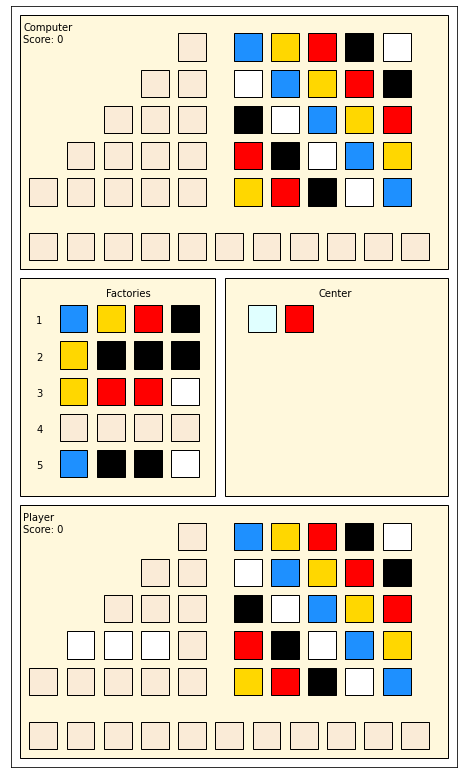

Computer's turn...


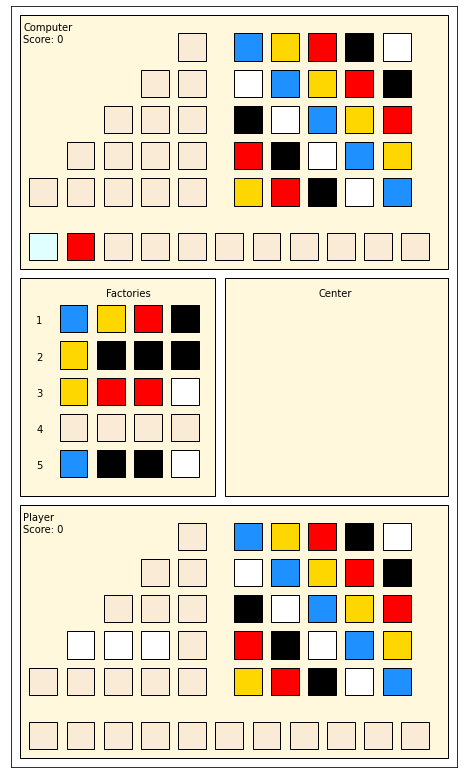

Player's turn...
Enter a move: 


KeyboardInterrupt: ignored

In [35]:
# Run this cell to play against our model
print("Welcome to the Azul simulator!")
print()

computer_turn = True
end = False
first_turn = True
board = init_board()
rng = np.random.default_rng(6546547)

while not end:
    if computer_turn:
        if not first_turn:
          print("Computer's turn...")
    else:
        print("Player's turn...")
        print("Enter a move: ")
    
    # Flip the state to put all player data in the current player section
    if not computer_turn:
        board = flip_board(board)
        invalid_action_or_input = True

        while invalid_action_or_input:
            input_string = input()
            board, error = take_action_from_string(board, input_string, rng)

            # Validate input_string
            if error:
                print("Enter a different move: ")
                continue
            invalid_action_or_input = False
        board = flip_board(board)
    else:
        action = learned_agent(board, state)
        board = get_next_state(board, action, rng)

    reward, end = get_reward(board)
    if end and reward == -1:
        print()
        print("Computer wins!!!")
        break
    elif end and reward == 1:
        print()
        print("Player wins!!!")
        break

    plot_state(board)
    plt.show()
    first_turn = False

    if board[Action_Indices.NOOP.value] == 1:
        board = get_next_state(board, Action_Indices.NOOP.value, rng)
    else:
        computer_turn = not computer_turn

If you played against the pre-trained Azul agent, you can see that it plays rather poorly. Despite being built using the same code that delivered a successful tic-tac-toe agent, it still loses frequently to an agent that simply selects a move at random from the list of legal moves. How can this be explained? We won't know for sure without more research, but we propose two theories. For each of the following, explain why this fact could be a cause of the dramatic drop in effectiveness from our tic-tac-toe agent to our Azul agent.

### Azul has a total of 181 possible actions, whereas tic-tac-toe only has 9.
Answer:

### While Azul is a perfect information game, there is a component of randomness when tiles are being shuffled and placed out onto the factories.
Answer:
